In [49]:
import pandas as pd #For reading dataset files
import networkx as nx #For network creation/analysis
from networkx.algorithms import community
import community as community_louvain
import matplotlib.pyplot as plt #For plotting graphs
import igraph as ig
import numpy as np
import leidenalg as la
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    f1_score,
    confusion_matrix,
)
from collections import Counter
from networkx.algorithms.community import label_propagation_communities
from cdlib import algorithms

from modularitydensity.metrics import modularity_density
import community as louvain
import leidenalg as la
from cdlib.algorithms import louvain

from cdlib import evaluation

import random

np.random.seed(42)
random.seed(42)

# Login dataset

Comunita_1: ['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'Patchback', 'PL', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN96', 'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR88', 'TR99', 'Trigger', 'TSN103', 'TSN83', 'Vau', 'Whitetip', 'Zap', 'Zipfel']
Comunita_2: ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']


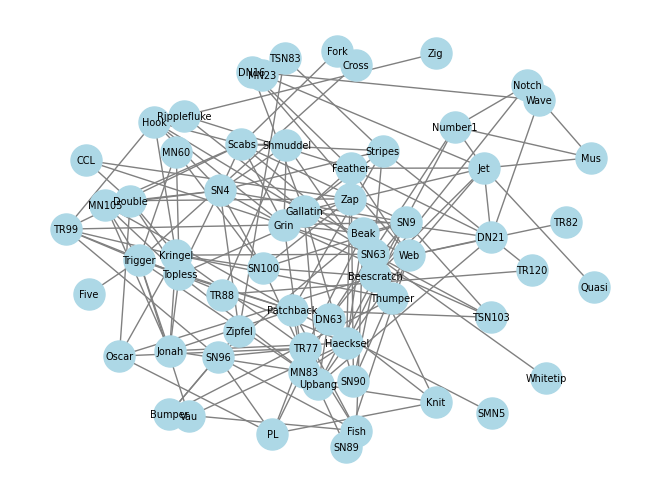

In [50]:
# Percorso del file GML
file_path = 'C:/Users/lulyd/Downloads/dolphins/dolphins.gml'

# Leggi il grafo dal file GML
G = nx.read_gml(file_path)

# Definisci le comunità (modifica secondo il tuo caso)
communities = {
    'Comunita_1': [0, 2, 3, 4, 8, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 58, 59, 61],
    'Comunita_2': [1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
}

# Sostituisci gli ID con i nomi dei nodi

def get_communities_as_lists(communities, G):
    node_list = list(G.nodes)
    community_lists = {name: [] for name in communities.keys()}

    for name, ids in communities.items():
        for id in ids:
            if id < len(node_list):
                community_lists[name].append(node_list[id])

    return community_lists

# Esegui la sostituzione
community_lists = get_communities_as_lists(communities, G)

# Stampa il risultato
for name, members in community_lists.items():
    print(f"{name}:", members)

# Disegna il grafo con una disposizione migliore
pos = nx.spring_layout(G, k=1)  # Aumenta k per maggiore spaziatura

# Disegna il grafo
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=7)  # Font size ridotto

# Mostra il grafo

plt.axis('off')  # Rimuove gli assi per una visualizzazione più pulita
plt.show()



In [51]:
def calcola_metriche(comunita_attese, comunita_rilevate, adjacency_matrix):
    # Creazione della mappatura dei nodi a indici
    nodi = []
    for community in comunita_attese.values():
        nodi.extend(community)
    nodo_to_index = {nodo: idx for idx, nodo in enumerate(nodi)}

    # Preparazione dei dati per ARI e NMI
    true_labels = np.zeros(len(nodi), dtype=int)  # Etichette vere
    for community_id, community_nodes in comunita_attese.items():
        for node in community_nodes:
            true_labels[nodo_to_index[node]] = int(community_id[-1])  # Usa l'ID della comunità

    predicted_labels = np.full(len(nodi), -1)  # Valori non assegnati    
    for cluster_id, nodes in comunita_rilevate.items():
        for node in nodes:
            if node in nodo_to_index:  # Assicurati che il nodo esista nella mappatura
                predicted_labels[nodo_to_index[node]] = int(cluster_id)  # Usa l'ID della comunità

    # Calcolo delle metriche
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    # Calcolo dell'HS
    hs = homogeneity_score(true_labels, predicted_labels)

    # Calcolo del CS
    cs = completeness_score(true_labels, predicted_labels)

    # Calcolo della F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calcolo della Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Calcolo della Modularity Density
    md = modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Score
    cs_score = community_score(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Fitness
    fitness = community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Stampa dei risultati
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
    print(f"Homogeneity Score (HS): {hs:.4f}")
    print(f"Completeness Score (CS): {cs:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Modularity Density: {md:.4f}")
    print(f"Community Score: {cs_score:.4f}")
    print(f"Community Fitness: {fitness:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


    # Risultati da visualizzare
    metriche = {
        'ARI': ari,
        'AMI': ami,
        'HS': hs,
        'CS': cs,
        'F1 Score': f1,
        'Modularity Density': md,
        'Community Score': cs_score,
        'Community Fitness': fitness,
        'NMI': nmi
    }

    return metriche

    # Creazione del grafico a barre
    plt.figure(figsize=(10, 6))
    plt.bar(metriche.keys(), metriche.values(), color='skyblue')
    plt.ylabel('Valore')
    plt.title('Metriche di Rilevamento delle Comunità')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


    x = np.arange(len(labels))
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, true_values, width=bar_width, label='Comunità Attese', color='skyblue')
    plt.bar(x + bar_width/2, predicted_values, width=bar_width, label='Comunità Rilevate', color='salmon')
    plt.xlabel('Comunità')
    plt.ylabel('Numero di Nodi')
    plt.title('Confronto tra Comunità Attese e Rilevate')
    plt.xticks(x, ['Comunita_1', 'Comunita_2'])
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
#  Funzioni di supporto 
def modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index):
    k = len(comunita_rilevate)  # Numero di comunità
    densita = 0.0  # Inizializza la densità a zero

    for community in comunita_rilevate.values():
        V_c = len(community)  # Numero di nodi nella comunità
        E_c = 0  # Inizializza il conteggio degli archi nella comunità

        # Calcola il numero di archi tra i nodi nella comunità
        for i in range(V_c):
            for j in range(i + 1, V_c):  # Evita il conteggio doppio
                idx_i = nodo_to_index[community[i]]
                idx_j = nodo_to_index[community[j]]
                if adjacency_matrix[idx_i, idx_j] > 0:
                    E_c += 1

        # Calcola la densità della comunità
        if V_c > 1:  # Evita divisioni per zero
            densita += E_c / (V_c * (V_c - 1))

    # Calcola la densità modulare finale
    if k > 0:  # Evita divisioni per zero
        densita_modulare = densita / k
    else:
        densita_modulare = 0

    return densita_modulare

def community_score(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    total_edges = 0
    num_nodes = adjacency_matrix.shape[0]

    for community in comunita_rilevate.values():
        for i in range(len(community)):
            for j in range(i + 1, len(community)):  # Per evitare il conteggio doppio
                node_i = community[i]
                node_j = community[j]
                if adjacency_matrix[nodo_to_index[node_i], nodo_to_index[node_j]] > 0:
                    internal_edges += 1
    
    # Conta anche gli archi totali nel grafo
    total_edges = np.sum(adjacency_matrix) / 2  # Dato che è una matrice simmetrica

    if total_edges == 0:
        return 0  # Evita divisioni per zero
    return internal_edges / total_edges


def community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    external_edges = 0
    num_nodes = adjacency_matrix.shape[0]  # Assicurati che la matrice sia quadrata

    node_to_community = {}
    for community_id, nodes in comunita_rilevate.items():
        for node in nodes:
            node_to_community[node] = community_id

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] > 0:  # Se esiste un arco
                node_i = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(i)]
                node_j = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(j)]
                if node_to_community.get(node_i) == node_to_community.get(node_j):  # Se appartengono alla stessa comunità
                    internal_edges += 1
                else:
                    external_edges += 1

    total_edges = internal_edges + external_edges

    # Evita divisioni per zero
    if total_edges == 0:
        return 0

    return internal_edges / total_edges

# Label propagation

Community 1: ['Notch', 'Ripplefluke', 'Upbang', 'Jet', 'Knit', 'TR82', 'Web', 'SN90', 'Zig', 'Beescratch', 'DN16', 'Gallatin', 'Wave', 'Quasi', 'Number1', 'SN89', 'DN63', 'MN23', 'Mus', 'Feather', 'DN21']
Community 2: ['MN83', 'SN100', 'SN4', 'CCL', 'MN60', 'SMN5', 'Trigger', 'Zap', 'Vau', 'SN9', 'Topless', 'Patchback', 'MN105', 'Five', 'Jonah', 'Cross', 'Double', 'Haecksel']
Community 3: ['Hook', 'Fork', 'Stripes', 'Thumper', 'Grin', 'Whitetip', 'Kringel', 'TSN103', 'TR99', 'Scabs', 'Shmuddel', 'SN63']
Community 4: ['PL', 'Bumper', 'Fish', 'Beak', 'Oscar', 'TR77', 'SN96']
Community 5: ['TR88', 'TR120']
Community 6: ['TSN83', 'Zipfel']


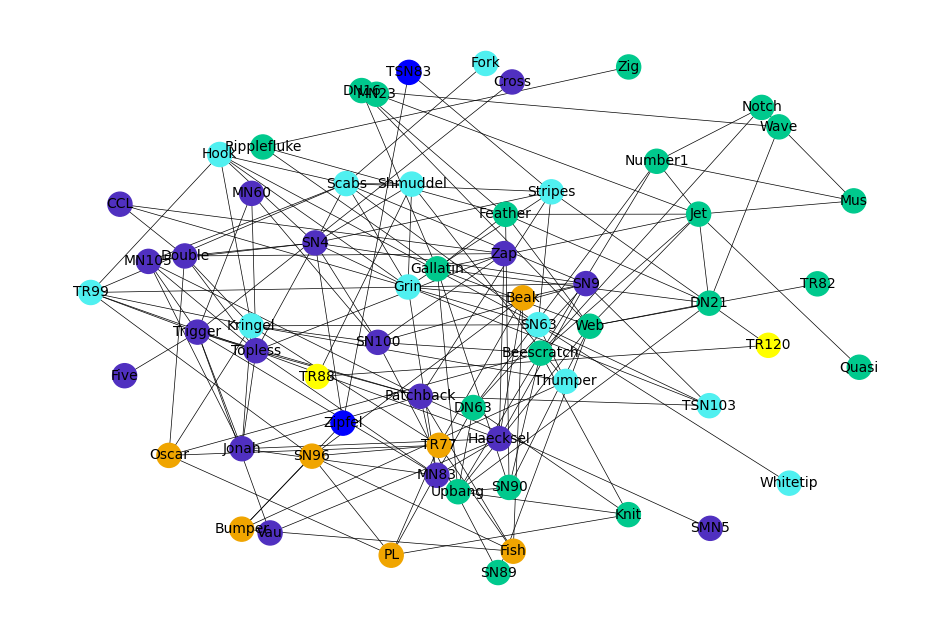

Adjusted Rand Index (ARI): 0.3614
Adjusted Mutual Information (AMI): 0.5051
Homogeneity Score (HS): 0.8969
Completeness Score (CS): 0.3731
F1 Score: 0.4065
Confusion Matrix:
[[ 0  0  0  0  0  0]
 [ 1 18 12  7  2  2]
 [20  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
Modularity Density: 0.0252
Community Score: 0.2075
Community Fitness: 0.2075
Normalized Mutual Information (NMI): 0.5270


In [52]:
community_graph = nx.Graph() 
# Rilevamento delle comunità con l'algoritmo Label Propagation
communities= algorithms.label_propagation(G).communities
community_dict_label_propagation = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)


# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", "#F0A500", 'yellow', 'blue']

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(G, pos, width=0.5)  # Aumenta la larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Riduci la dimensione delle etichette
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Comunita_1': ['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'Patchback', 'PL', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN96', 'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR88', 'TR99', 'Trigger', 'TSN103', 'TSN83', 'Vau', 'Whitetip', 'Zap', 'Zipfel'],
    'Comunita_2': ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']


}

adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_label_propagation = calcola_metriche(ground_truth_communities, community_dict_label_propagation, adj_matrix_full)

# Louvain

Community 1: ['Fork', 'Grin', 'Hook', 'Kringel', 'Scabs', 'Shmuddel', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'Stripes', 'Thumper', 'TR120', 'TR88', 'TR99', 'TSN103', 'TSN83', 'Whitetip', 'Zipfel']
Community 2: ['Beescratch', 'DN16', 'DN21', 'Feather', 'Gallatin', 'Jet', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']
Community 3: ['CCL', 'Cross', 'Double', 'Five', 'Haecksel', 'Jonah', 'MN105', 'MN60', 'MN83', 'Patchback', 'SMN5', 'Topless', 'Trigger', 'Vau', 'Zap']
Community 4: ['Beak', 'Bumper', 'DN63', 'Fish', 'Knit', 'Oscar', 'PL', 'SN96', 'TR77']


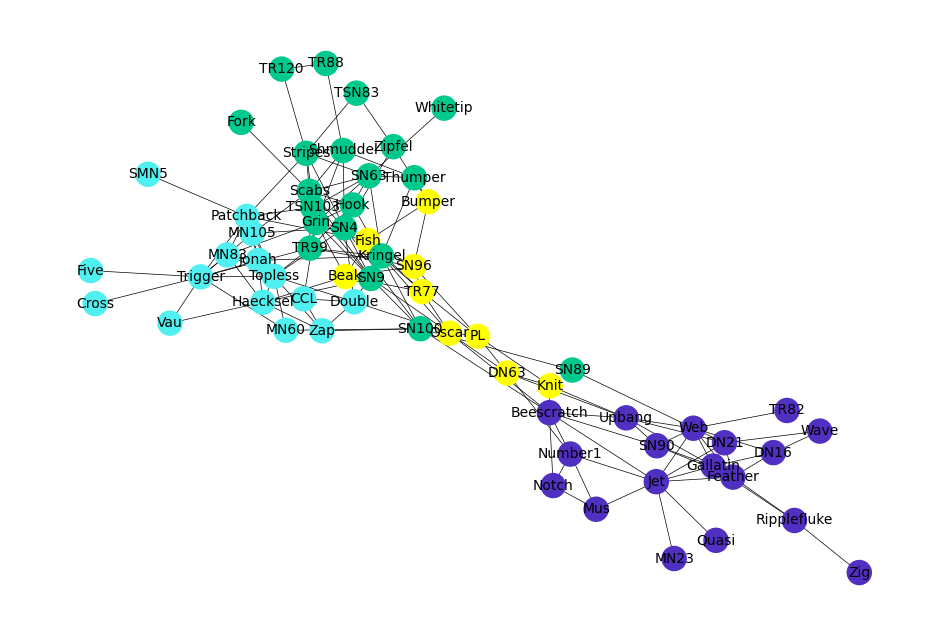

Adjusted Rand Index (ARI): 0.4032
Adjusted Mutual Information (AMI): 0.5467
Homogeneity Score (HS): 0.8777
Completeness Score (CS): 0.4096
F1 Score: 0.0000
Confusion Matrix:
[[ 0  0  0  0]
 [20  0 15  7]
 [ 0 18  0  2]
 [ 0  0  0  0]]
Modularity Density: 0.0367
Community Score: 0.2327
Community Fitness: 0.2327
Normalized Mutual Information (NMI): 0.5585


In [53]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)
communities = algorithms.louvain(G).communities
community_dict_louvain = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", 'yellow', 'cyan', 'magenta', 'orange']

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(G, pos, width=0.5)  # Aumenta la larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Riduci la dimensione delle etichette
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
  'Comunita_1': ['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'Patchback', 'PL', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN96', 'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR88', 'TR99', 'Trigger', 'TSN103', 'TSN83', 'Vau', 'Whitetip', 'Zap', 'Zipfel'],
  'Comunita_2': ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']
}

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_louvain = calcola_metriche(ground_truth_communities, community_dict_louvain, adj_matrix_full)

# Leiden

Community 1: ['Beescratch', 'DN16', 'DN21', 'Feather', 'Gallatin', 'Jet', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']
Community 2: ['Fork', 'Grin', 'Hook', 'Scabs', 'Shmuddel', 'SN4', 'SN63', 'SN9', 'Stripes', 'Thumper', 'TR120', 'TR88', 'TR99', 'TSN103', 'TSN83', 'Whitetip', 'Zipfel']
Community 3: ['Cross', 'Five', 'Haecksel', 'Jonah', 'MN105', 'MN60', 'MN83', 'Patchback', 'SMN5', 'Topless', 'Trigger', 'Vau']
Community 4: ['Beak', 'Bumper', 'DN63', 'Fish', 'Knit', 'PL', 'SN96', 'TR77']
Community 5: ['CCL', 'Double', 'Kringel', 'Oscar', 'SN100', 'SN89', 'Zap']


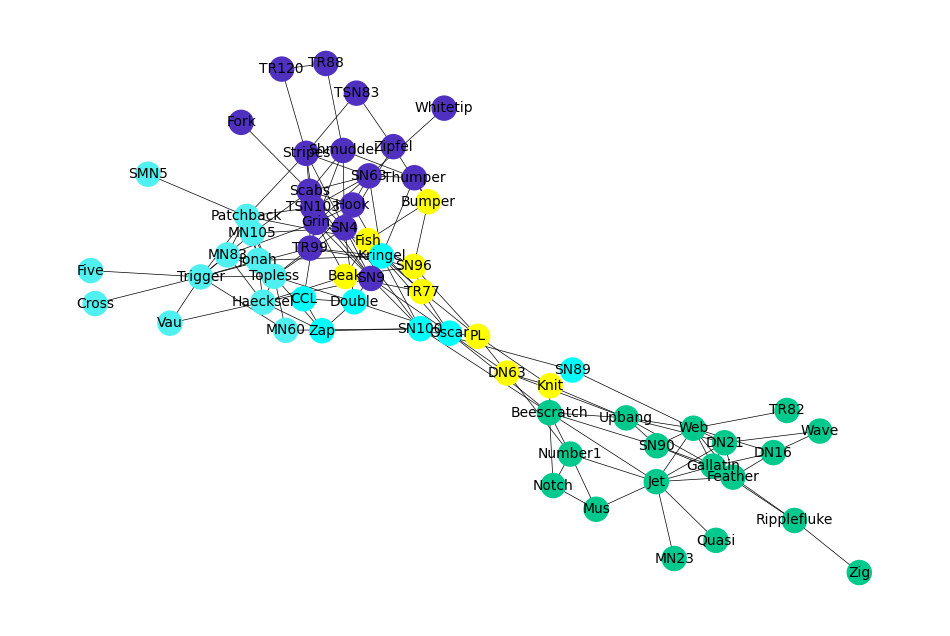

Adjusted Rand Index (ARI): 0.3329
Adjusted Mutual Information (AMI): 0.4961
Homogeneity Score (HS): 0.8846
Completeness Score (CS): 0.3607
F1 Score: 0.3904
Confusion Matrix:
[[ 0  0  0  0  0]
 [ 0 17 12  6  7]
 [18  0  0  2  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
Modularity Density: 0.0354
Community Score: 0.2075
Community Fitness: 0.2075
Normalized Mutual Information (NMI): 0.5124


In [54]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)

communities = algorithms.leiden(G).communities
community_dict_leiden = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", 'yellow', 'cyan', 'magenta', 'orange']

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

# Disegna il grafo
plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(G, pos, width=0.5)  # Aumenta la larghezza degli archi
nx.draw_networkx_nodes(G, pos, node_color=[color_map_b[node] for node in G.nodes()])
nx.draw_networkx_labels(G, pos, font_size=10)  # Riduci la dimensione delle etichette
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Comunita_1': ['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'Patchback', 'PL', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN96', 'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR88', 'TR99', 'Trigger', 'TSN103', 'TSN83', 'Vau', 'Whitetip', 'Zap', 'Zipfel'],
    'Comunita_2': ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']
}

#Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_leiden = calcola_metriche(ground_truth_communities, community_dict_leiden, adj_matrix_full)


# Conga

Communities detected:
Communità 1: ['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'Patchback', 'PL', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN9', 'SN96', 'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR88', 'TR99', 'Trigger', 'TSN103', 'TSN83', 'Vau', 'Whitetip', 'Zap', 'Zipfel']
Communità 2: ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN89', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig', 'SN100', 'PL']


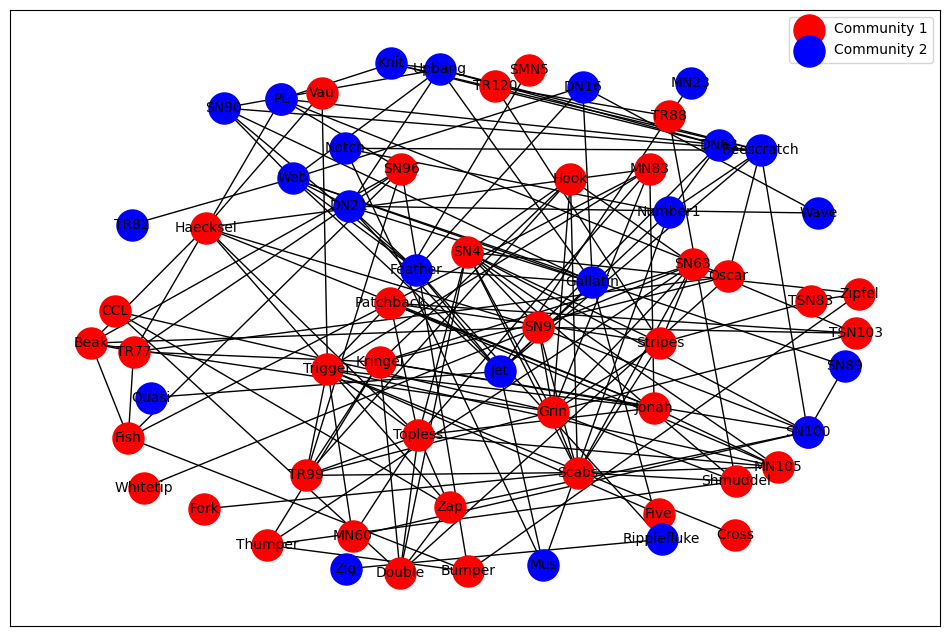

Adjusted Rand Index (ARI): 0.8117
Adjusted Mutual Information (AMI): 0.7500
Homogeneity Score (HS): 0.7716
Completeness Score (CS): 0.7357
F1 Score: 0.0625
Confusion Matrix:
[[ 0  0  0]
 [39  3  0]
 [ 0 20  0]]
Modularity Density: 0.0383
Community Score: 0.5786
Community Fitness: 0.5409
Normalized Mutual Information (NMI): 0.7532


In [55]:
# Run the CONGA algorithm
com = algorithms.conga(G, number_communities=2)
community_dict = {i: community for i, community in enumerate(com.communities)}

# Print the detected communities
print("Communities detected:")
for i, community in enumerate(com.communities):
    print(f"Communità {i + 1}: {community}")

# Prepare for visualization
pos = nx.spring_layout(G, k=1.5)  # Layout for the nodes
colors = (['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow'])  # Cycle through colors

# Draw the graph with community coloring
plt.figure(figsize=(12, 8))
for community, color in zip(com.communities, colors):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=color, label=f"Community {com.communities.index(community) + 1}", node_size=500)

# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=1)
nx.draw_networkx_labels(G, pos, font_size=10)  # Dimensione ridotta delle etichette


# Add a legend and show the plot
plt.legend(scatterpoints=1)
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Comunita_1': ['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'Patchback', 'PL', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN96', 'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR88', 'TR99', 'Trigger', 'TSN103', 'TSN83', 'Vau', 'Whitetip', 'Zap', 'Zipfel'],
    'Comunita_2': ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']
}

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_conga = calcola_metriche(ground_truth_communities, community_dict, adj_matrix_full)

                    Label Propagation   Louvain    Leiden     Conga
ARI                          0.361361  0.403206  0.332950  0.811720
AMI                          0.505064  0.546690  0.496072  0.749955
HS                           0.896877  0.877715  0.884606  0.771559
CS                           0.373130  0.409577  0.360684  0.735677
F1 Score                     0.406452  0.000000  0.390377  0.062531
Modularity Density           0.025219  0.036728  0.035441  0.038298
Community Score              0.207547  0.232704  0.207547  0.578616
Community Fitness            0.207547  0.232704  0.207547  0.540881
NMI                          0.527008  0.558524  0.512432  0.753191
Numero di Comunità           6.000000  4.000000  5.000000  2.000000


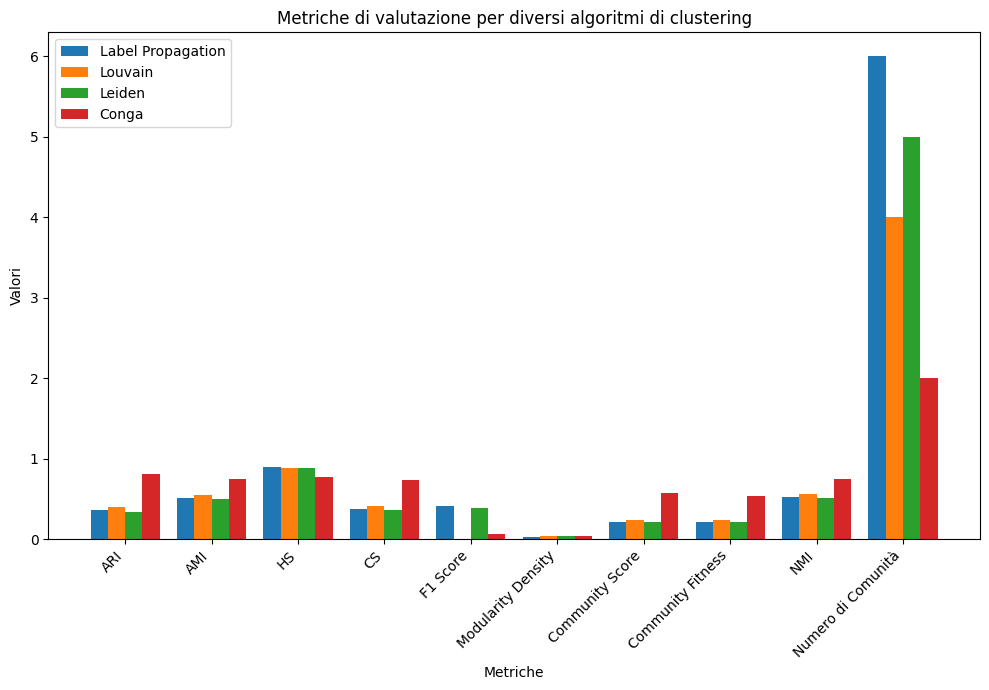

In [56]:
# Aggiungi il numero delle comunità rilevate per ciascun algoritmo nei risultati
risultati = {
    "Label Propagation": {**risultati_label_propagation, "Numero di Comunità": len(community_dict_label_propagation)},
    "Louvain": {**risultati_louvain, "Numero di Comunità": len(community_dict_louvain)},
    "Leiden": {**risultati_leiden, "Numero di Comunità": len(community_dict_leiden)},
    "Conga": {**risultati_conga, "Numero di Comunità": len(community_dict)}
}

# Creazione di un DataFrame dalle metriche ottenute per ogni algoritmo, inclusi il numero di comunità
df_risultati = pd.DataFrame(risultati)

# Visualizzazione del DataFrame per vedere i risultati
print(df_risultati)

# Imposta dimensioni della figura per il grafico
fig, ax = plt.subplots(figsize=(10, 7))

# Definire le posizioni delle barre
n_misure = len(df_risultati.index)
bar_width = 0.2
index = np.arange(n_misure)

# Plot delle barre
for i, algoritmo in enumerate(df_risultati.columns):
    ax.bar(index + i * bar_width, df_risultati[algoritmo], bar_width, label=algoritmo)

# Aggiungere etichette e titolo
ax.set_xlabel('Metriche')
ax.set_ylabel('Valori')
ax.set_title('Metriche di valutazione per diversi algoritmi di clustering')

# Configurazione delle etichette per l'asse X
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(df_risultati.index, rotation=45, ha='right')

# Aggiungere legenda
ax.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()
